# A-gs model and implementation (simulation CO2 and H2O flux)

## Initialize data and model

### Setup and fetch data

In [1]:
# Settings
Username   = 'Beheerder'
years      = range(2001,2020)    #(1997,2021) # Set years to download

In [2]:
import os
datapath   = os.path.join('../../') #since this file is 2 dir down from the data it's ../../
print('datapath is set to %s'%datapath)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly.express as px
#import cufflinks as cf
import matplotlib.dates as mdate
import matplotlib.ticker as ticker
from matplotlib import cm
#from colorspacious import cspace_converter
import scipy.stats as stats
#cf.go_offline()
# cf.set_config_file(offline=False, world_readable=True)

from datetime import datetime, timedelta
import sys
sys.path.insert(0, os.path.join(datapath,'PythonScripts'))
sys.path.append('../') #append the directory above this one to path to be able to find my python modules

from Loobos_Toolbox import dateparse, dateparse_Gapfilled, Read_LoobosEddFinal, Read_LooStor, Read_LoodatGapfill, Read_Loobos_halfhourly, Read_Loobos_meteo, Read_Loobos_soil, Read_Loobos_profile

from Ags_model import runAgs, runAgs2, calc_LE

datapath is set to ../../


In [3]:
#these next two lines are to prevent re-loading the data. If you want to re-load data, instead comment them out
if not 'progress' in globals(): progress = list()
if not 'dataloaded' in progress:
  # Read files
    df_EC           = Read_LoobosEddFinal    (years,datapath)
    df_Stor         = Read_LooStor           (years,datapath)
    df_Comb         = Read_LoodatGapfill     (years,datapath)
    df_NEE          = Read_Loobos_halfhourly (years,datapath)
    df_meteo        = Read_Loobos_meteo      (years,datapath)
    df_soil         = Read_Loobos_soil       (years,datapath) 
    df_profile      = Read_Loobos_profile    (years,datapath)
    progress.append('dataloaded')

Loading 2001
Loading 2002
Loading 2003
Loading 2004
Loading 2005
Loading 2006
Loading 2007
Loading 2008
Loading 2009
Loading 2010
Loading 2011
Loading 2012
Loading 2013
Loading 2014
Loading 2015
Loading 2016
Loading 2017
Loading 2018
Loading 2019
df_EC loaded. Columns in this dataframe:
Index(['Doy', 'Dtime', 'Flx_Tsonic', 'Flx_Lo-H2O', 'Flx_Lo-CO2', 'Qf_Tsonic',
       'Qf_Lo-H2O', 'Qf_Lo-CO2', 'Mea_Windsp', 'Mea_Tsonic', 'Mea_Lo-H2O',
       'Mea_Lo-CO2', 'U-star', 'Z-over-L', 'Wind-Dir', '80PercFlux'],
      dtype='object')
Loading 2001


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2002


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2003


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2004
Loading 2005


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2006


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2007


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2008
Loading 2009


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2010
Loading 2011


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2012
Loading 2013


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2014
Loading 2015


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser'

Loading 2016
Loading 2017
Loading 2018


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2019


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_Stor loaded. Columns in this dataframe:
Index(['Day', 'Time', 'TotalT', 'TotalTflux', 'TotalH2O', 'TotalH2Oflux',
       'TotalCO2', 'TotalCO2flux', 'CO2-2.5m', 'CO2flux-2.5m'],
      dtype='object')
Loading 2001
Loading 2002
Loading 2003
Loading 2004
Loading 2005
Loading 2006
Loading 2007
Loading 2008
Loading 2009
Loading 2010
Loading 2011
Loading 2012
Loading 2013
Loading 2014
Loading 2015
Loading 2016
Loading 2017
Loading 2018
Loading 2019
df_Comb loaded. Columns in this dataframe:
Index(['Year', 'DoY', 'Hour', 'qcNEE', 'NEE', 'LE', 'H', 'Rg', 'Tair', 'Tsoil',
       'rH', 'Ustar', 'VPD', 'NEE_orig', 'NEE_f', 'NEE_fqc', 'NEE_fall',
       'NEE_fall_qc', 'NEE_fnum', 'NEE_fsd', 'NEE_fmeth', 'NEE_fwin',
       'Rg_orig', 'Rg_f', 'Rg_fqc', 'Rg_fall', 'Rg_fall_qc', 'Rg_fnum',
       'Rg_fsd', 'Rg_fmeth', 'Rg_fwin', 'H_orig', 'H_f', 'H_fqc', 'H_fall',
       'H_fall_qc', 'H_fnum', 'H_fsd', 'H_fmeth', 'H_fwin', 'LE_orig', 'LE_f',
       'LE_fqc', 'LE_fall', 'LE_fall_qc', 'LE_fnum', 'LE_

C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2002


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2003
Loading 2004


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2005
Loading 2006


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2007
Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2009
Loading 2010


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_pa

Loading 2011
Loading 2012


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2013
Loading 2014


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2015
Loading 2016


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2017
Loading 2018


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2019
Done
df_NEE loaded. Columns in this dataframe:
Index(['NEE_f', 'H_f', 'LE_f', 'Reco_f', 'GPP_f', 'NEE_fqc', 'H_fqc', 'LEfqc',
       'Reco', 'Tair', 'Rg_f', 'VPD', 'Tsoil', 'rH', 'Ustar', 'R-ref', 'E_0'],
      dtype='object')
Loading 2001


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2002


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2003


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2004


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2005


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2006


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2007


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2009


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2010


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2011


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2012


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2013


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2014


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2015


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2016


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2017


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2018


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2019


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_meteo loaded. Columns in this dataframe:
Index(['Daynumber', 'Time', 'S(i)', 'S(o)', 'L(i)', 'L(o)', 'G1', 'PAR',
       'H2OLic', 'CO2Lic', '-q', 'Te(vaisal)', 'Te-L(i)', 'Te-L(o)', '-u(z)',
       '-u(dir)', 'Min u(z)', 'WSC therm', 'SD S(i)', 'SD S(o)', 'SD L(i)',
       'SD L(o)', 'SD G1', 'SD PAR', 'SD H2OLic', 'SD CO2Lic', 'SD q',
       'SD Te(vaisal)', 'Battery V', 'CR10 temp', 'P(mast)00', 'P(guter)00',
       'P(mast)05', 'P(guter)05', 'P(mast)10', 'P(guter)10', 'P(mast)15',
       'P(guter)15', 'P(mast)20', 'P(guter)20', 'P(mast)25', 'P(guter)25',
       'P(mast)', 'P(guter)', 'P(field)', 'L(i)corr', 'L(o)corr', 'R(net)',
       'P(guter)corr', 'Pcorr', 'PARrefl', 'PARdiff', 'H2Olic', 'CO2lic',
       'Vbatt', 'CR10temp', 'SD u(z)'],
      dtype='object')
Loading ../../\Soilmoist\Final\Loosoifinal01.csv...
Loading ../../\Soilmoist\Final\Loosoifinal02.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal03.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal04.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal05.csv...
Loading ../../\Soilmoist\Final\Loosoifinal06.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal07.csv...
Loading ../../\Soilmoist\Final\Loosoifinal08.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal09.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal10.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal11.csv...
Loading ../../\Soilmoist\Final\Loosoifinal12.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal13.csv...
Loading ../../\Soilmoist\Final\Loosoifinal14.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal15.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal16.csv...
Loading ../../\Soilmoist\Final\Loosoifinal17.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal18.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal19.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_soil loaded. Columns in this dataframe:
Index(['Time', 'Daynumber', 'Year', 'EC200', 'EC201', 'EC202', 'EC203',
       'EC204', 'EC205', 'EC206', 'EC207', 'EC208', 'EC209', 'Temp200',
       'Temp201', 'Temp202', 'Temp203', 'Temp204', 'Temp205', 'Temp206',
       'Temp207', 'Temp208', 'Temp209', 'Eps200co', 'Eps201co', 'Eps202co',
       'Eps203co', 'Eps204co', 'Eps205co', 'Eps206co', 'Eps207co', 'Eps208co',
       'Eps209co', 'SM-Lit', 'SM-003', 'SM-020', 'SM-050', 'SM-100', 'ST-Lit',
       'ST-003', 'ST-020', 'ST-050', 'ST-100', 'T-bole'],
      dtype='object')
Loading 2001


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2002


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2003


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2004


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2005


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2006


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2007


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2009


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2010


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2011


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2012


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2013


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2014


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2015
Loading 2016


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2017


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2018


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2019


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_profile loaded. Columns in this dataframe:
Index(['Daynumber', 'Time', 'Vtemptop', 'Vtempmid', 'Vtempbot', 'VaiVPtop',
       'VaiVPmid', 'Pressure', 'VecWStop', 'VecWSmid', 'VecWSbot', 'H2Olevel1',
       'H2Olevel2', 'H2Olevel3', 'H2Olevel4', 'H2Olevel5', 'CO2level1',
       'CO2level2', 'CO2level3', 'CO2level4', 'CO2level5', 'H2Ocal', 'CO2cal'],
      dtype='object')


In [4]:
from FilterData import Filter_wrap
CO2,Locorr,VPD,Ustar,df_profile_filter,df_meteo_filter,df_Comb_filter,df_EC_filter=Filter_wrap(df_Comb,df_profile,df_meteo,df_EC,filterversion='default')
#NOTE: df_Stor is NOT FILTERED

In [5]:
from FilterData import Filter_GPP_LE_NEE_VPD 
df_Comb_filter2 = Filter_GPP_LE_NEE_VPD(df_Comb,fqc=None)

### Run A-gs model

In [6]:
# Run A-gs model
fstr=1.0
an_final,an_umol,rs, ra, Ts_C = runAgs2(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr)

## Calcuate ET

### Assemble dataframe 'df_ET' that will hold output and fill with inputs

In [7]:
df_ET = pd.concat([df_meteo['L(o)'],df_meteo['Te-L(o)'],df_profile['Pressure'],df_Comb['VPD'],df_Comb['rH'],df_meteo['P(mast)']],axis=1,sort=False)
#convert Pressure from hPa to kPa 
df_ET['p_kPa']=df_ET['Pressure']/10
df_ET['VPD_adj']=df_ET['VPD'].loc[df_ET['VPD']>0] #some outlier values for VPD are negative, remove from dataset
df_ET['VPD_adj']=df_ET['VPD_adj']/10  # VPD from df_Comb is in hPa, I need kPa, so hPa/10 = kPa

### calculate ET

In [8]:
def init_ETframe(rs_series):
    df_ET = pd.concat([df_meteo['L(o)'],df_meteo['Te-L(o)'],df_profile['Pressure'],df_Comb['VPD'],df_Comb['rH'],df_meteo['P(mast)']],axis=1,sort=False)
    #convert Pressure from hPa to kPa 
    df_ET['p_kPa']=df_ET['Pressure']/10
    df_ET['VPD_adj']=df_ET['VPD'].loc[df_ET['VPD']>0] #some outlier values for VPD are negative, remove from dataset
    df_ET['VPD_adj']=df_ET['VPD_adj']/10  # VPD from df_Comb is in hPa, I need kPa, so hPa/10 = kPa
    df_ET['rs']=rs_series.to_frame(name="rs")
    df_ET['ra']=ra.to_frame(name="ra")
    return df_ET

In [9]:
df_ET=init_ETframe(rs)

In [10]:
df_ET=calc_LE(df_ET)

## Sensitivy analysis plots

### CO2 flux

### scatterplot colored by hour, with black markers for one single year (2018)

Text(0, 0.5, 'Hour')

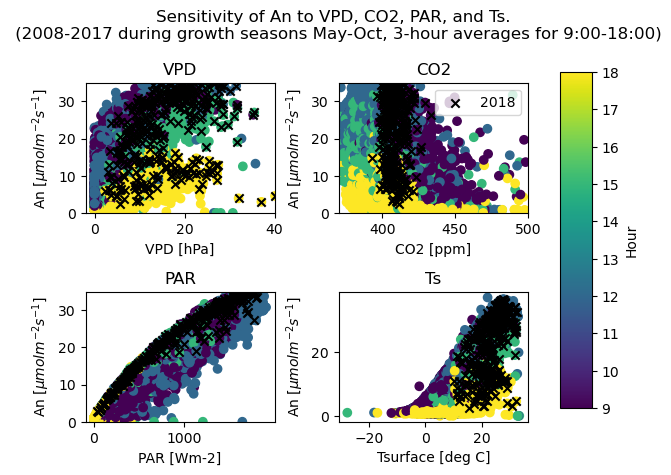

In [11]:
start='2008-05-01 00:00'
end='2018-08-30 00:00'
st='2018-05-01 00:00'
ed='2018-08-30 00:00'
time_s="9:00"
time_e="18:00"


sim_data_VPD=df_Comb_filter.loc[start:end,'VPD'].resample('3H').mean().between_time(time_s,time_e)
sim_data_VPD=sim_data_VPD.dropna() #eliminate NaN entries created by the .loc slice
sim_data_CO2=df_profile_filter.loc[start:end,'CO2level1'].resample('3H').mean().between_time(time_s,time_e)
sim_data_CO2=sim_data_CO2.dropna() #eliminate NaN entries created by the .loc slice
sim_data_PAR=df_meteo_filter.loc[start:end,'PAR'].resample('3H').mean().between_time(time_s,time_e)
sim_data_PAR=sim_data_PAR.dropna() #eliminate NaN entries created by the .loc slice

Ts_data=Ts_C.loc[start:end].resample('3H').mean().between_time(time_s,time_e)
Ts_data=Ts_data.rename('Ts_data') #turn into a named series so it works with df.merge() properly
#Ts_data=Ts_data.resample('3H').mean()#.between_time("11:00", "18:00")
Ts_data=Ts_data.dropna() #eliminate NaN entries created by the .loc slice

an_data=an_umol.loc[start:end].resample('3H').mean().between_time(time_s,time_e)
an_data=an_data.dropna() #eliminate NaN entries created by the .loc slice
an_data=an_data.rename('an_data') #turn into a named series so it works with df.merge() properly


df_tmp1 = pd.DataFrame()
df_tmp1['an_data']=an_data
df_tmp1=df_tmp1.merge(sim_data_VPD, how='inner',left_index=True, right_index=True)

df_tmp2 = pd.DataFrame()
df_tmp2['an_data']=an_data
df_tmp2=df_tmp2.merge(sim_data_CO2, how='inner',left_index=True, right_index=True)

df_tmp3 = pd.DataFrame()
df_tmp3['an_data']=an_data
df_tmp3=df_tmp3.merge(sim_data_PAR, how='inner',left_index=True, right_index=True)

df_tmp4 = pd.DataFrame()
df_tmp4['an_data']=an_data
df_tmp4=df_tmp4.merge(Ts_data, how='inner',left_index=True, right_index=True)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
fig.suptitle('Sensitivity of An to VPD, CO2, PAR, and Ts. \n (2008-2017 during growth seasons May-Oct, 3-hour averages for 9:00-18:00)')

p1=ax1.scatter(df_tmp1['VPD'],df_tmp1['an_data'],marker='o',c=df_tmp1.index.hour,cmap='viridis') #scatter(x,y)
p1a=ax1.scatter(df_tmp1.loc[st:ed,'VPD'],df_tmp1.loc[st:ed,'an_data'],marker='x',c='black') #scatter(x,y)
ax1.set_ylim(0,35)
ax1.set_xlim(-2,40)
ax1.set_xlabel('VPD [hPa]')
ax1.set_ylabel(r'An [$\mu molm^{-2}s^{-1}$]')
ax1.set_title('VPD')

p2=ax2.scatter(df_tmp2['CO2level1'],df_tmp2['an_data'],marker='o',c=df_tmp2.index.hour,cmap='viridis') #scatter(x,y)
p2a=ax2.scatter(df_tmp2.loc[st:ed,'CO2level1'],df_tmp2.loc[st:ed,'an_data'],marker='x',c='black',label='2018') #scatter(x,y)
ax2.set_ylim(0,35)
ax2.set_xlim(370,500)
ax2.set_xlabel('CO2 [ppm]')
ax2.set_ylabel(r'An [$\mu molm^{-2}s^{-1}$]')
ax2.set_title('CO2')

p3=ax3.scatter(df_tmp3['PAR'],df_tmp3['an_data'],marker='o',c=df_tmp3.index.hour,cmap='viridis') #scatter(x,y)
p3a=ax3.scatter(df_tmp3.loc[st:ed,'PAR'],df_tmp3.loc[st:ed,'an_data'],marker='x',c='black') #scatter(x,y)
ax3.set_ylim(0,35)
#ax3.set_xlim(-2,40)
ax3.set_xlabel(r'PAR [Wm-2]')
ax3.set_ylabel(r'An [$\mu molm^{-2}s^{-1}$]')
ax3.set_title('PAR')

p4=ax4.scatter(df_tmp4['Ts_data'],df_tmp4['an_data'],marker='o',c=df_tmp4.index.hour,cmap='viridis') #scatter(x,y)
p4a=ax4.scatter(df_tmp4.loc[st:ed,'Ts_data'],df_tmp4.loc[st:ed,'an_data'],marker='x',c='black') #scatter(x,y)
#ax4.set_ylim(0,35)
#ax4.set_xlim(-20,35)
ax4.set_xlabel(r'Tsurface [deg C]')
ax4.set_ylabel(r'An [$\mu molm^{-2}s^{-1}$]')
ax4.set_title('Ts')

ax2.legend()

fig.tight_layout()
#fig.subplots_adjust(top=0.80) #fix the top margin text overlap  
#cbar=plt.colorbar(p1,ax=ax)
#cbar.ax.set_ylabel('Hour')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p1, cax=cbar_ax)
cbar_ax.set_ylabel('Hour')

### Scatterplot colored by Hour regular

Text(0, 0.5, 'Hour')

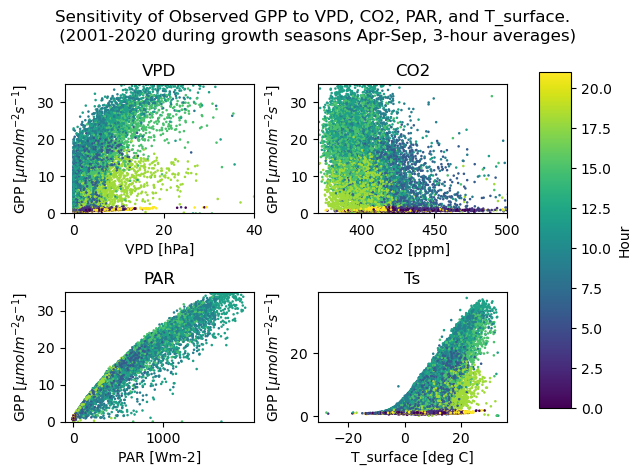

In [12]:
start='2008-05-01 00:00'
end='2018-08-30 00:00'

sim_data_VPD=df_Comb_filter.loc[start:end,'VPD'].resample('3H').mean()#.between_time("11:00", "18:00")
sim_data_VPD=sim_data_VPD.dropna() #eliminate NaN entries created by the .loc slice
sim_data_CO2=df_profile_filter.loc[start:end,'CO2level1'].resample('3H').mean()#.between_time("11:00", "18:00")
sim_data_CO2=sim_data_CO2.dropna() #eliminate NaN entries created by the .loc slice
sim_data_PAR=df_meteo_filter.loc[start:end,'PAR'].resample('3H').mean()#.between_time("11:00", "18:00")
sim_data_PAR=sim_data_PAR.dropna() #eliminate NaN entries created by the .loc slice

Ts_data=Ts_C.loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
Ts_data=Ts_data.rename('Ts_data') #turn into a named series so it works with df.merge() properly
Ts_data=Ts_data.resample('3H').mean()#.between_time("11:00", "18:00")
Ts_data=Ts_data.dropna() #eliminate NaN entries created by the .loc slice

an_data=an_umol.loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
an_data=an_data.dropna() #eliminate NaN entries created by the .loc slice
an_data=an_data.rename('an_data') #turn into a named series so it works with df.merge() properly


df_tmp1 = pd.DataFrame()
df_tmp1['an_data']=an_data
df_tmp1=df_tmp1.merge(sim_data_VPD, how='inner',left_index=True, right_index=True)

df_tmp2 = pd.DataFrame()
df_tmp2['an_data']=an_data
df_tmp2=df_tmp2.merge(sim_data_CO2, how='inner',left_index=True, right_index=True)

df_tmp3 = pd.DataFrame()
df_tmp3['an_data']=an_data
df_tmp3=df_tmp3.merge(sim_data_PAR, how='inner',left_index=True, right_index=True)

df_tmp4 = pd.DataFrame()
df_tmp4['an_data']=an_data
df_tmp4=df_tmp4.merge(Ts_data, how='inner',left_index=True, right_index=True)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
fig.suptitle('Sensitivity of Observed GPP to VPD, CO2, PAR, and T_surface. \n (2001-2020 during growth seasons Apr-Sep, 3-hour averages)')

p1=ax1.scatter(df_tmp1['VPD'],df_tmp1['an_data'],marker='o',c=df_tmp1.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
ax1.set_ylim(0,35)
ax1.set_xlim(-2,40)
ax1.set_xlabel('VPD [hPa]')
ax1.set_ylabel(r'GPP [$\mu molm^{-2}s^{-1}$]')
ax1.set_title('VPD')

p2=ax2.scatter(df_tmp2['CO2level1'],df_tmp2['an_data'],marker='o',c=df_tmp1.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
ax2.set_ylim(0,35)
ax2.set_xlim(370,500)
ax2.set_xlabel('CO2 [ppm]')
ax2.set_ylabel(r'GPP [$\mu molm^{-2}s^{-1}$]')
ax2.set_title('CO2')

p1=ax3.scatter(df_tmp3['PAR'],df_tmp3['an_data'],marker='o',c=df_tmp1.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
ax3.set_ylim(0,35)
#ax3.set_xlim(-2,40)
ax3.set_xlabel(r'PAR [Wm-2]')
ax3.set_ylabel(r'GPP [$\mu molm^{-2}s^{-1}$]')
ax3.set_title('PAR')

p1=ax4.scatter(df_tmp4['Ts_data'],df_tmp4['an_data'],marker='o',c=df_tmp1.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
#ax4.set_ylim(0,35)
#ax4.set_xlim(-20,35)
ax4.set_xlabel(r'T_surface [deg C]')
ax4.set_ylabel(r'GPP [$\mu molm^{-2}s^{-1}$]')
ax4.set_title('Ts')

fig.tight_layout()
#fig.subplots_adjust(top=0.80) #fix the top margin text overlap  
#cbar=plt.colorbar(p1,ax=ax)
#cbar.ax.set_ylabel('Hour')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p1, cax=cbar_ax)
cbar_ax.set_ylabel('Hour')

## H2O flux

Text(0, 0.5, 'Hour')

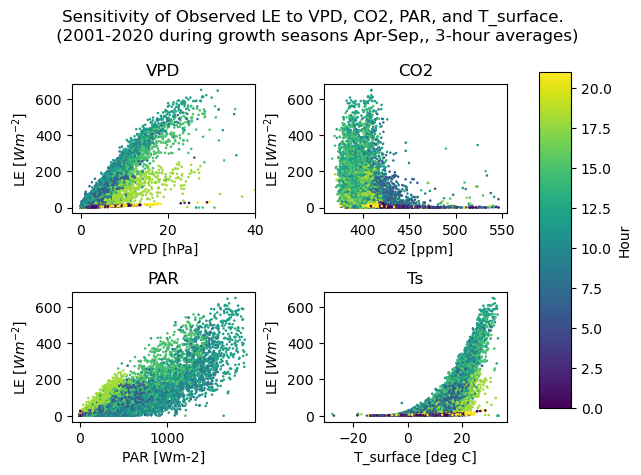

In [13]:
start='2008-05-01 00:00'
end='2018-08-30 00:00'

sim_data_VPD=df_Comb_filter.loc[start:end,'VPD'].resample('3H').mean()#.between_time("11:00", "18:00")
sim_data_VPD=sim_data_VPD.dropna() #eliminate NaN entries created by the .loc slice
sim_data_CO2=df_profile_filter.loc[start:end,'CO2level1'].resample('3H').mean()#.between_time("11:00", "18:00")
sim_data_CO2=sim_data_CO2.dropna() #eliminate NaN entries created by the .loc slice
sim_data_PAR=df_meteo_filter.loc[start:end,'PAR'].resample('3H').mean()#.between_time("11:00", "18:00")
sim_data_PAR=sim_data_PAR.dropna() #eliminate NaN entries created by the .loc slice

Ts_data=Ts_C.loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
Ts_data=Ts_data.rename('Ts_data') #turn into a named series so it works with df.merge() properly
Ts_data=Ts_data.resample('3H').mean()#.between_time("11:00", "18:00")
Ts_data=Ts_data.dropna() #eliminate NaN entries created by the .loc slice

LE_data=df_ET.loc[start:end,'ET_VPD'].resample('3H').mean()#.between_time("11:00", "18:00")
LE_data=LE_data.dropna() #eliminate NaN entries created by the .loc slice
LE_data=LE_data.rename('LE_data') #turn into a named series so it works with df.merge() properly


df_tmp1 = pd.DataFrame()
df_tmp1['LE_data']=LE_data
df_tmp1=df_tmp1.merge(sim_data_VPD, how='inner',left_index=True, right_index=True)

df_tmp2 = pd.DataFrame()
df_tmp2['LE_data']=LE_data
df_tmp2=df_tmp2.merge(sim_data_CO2, how='inner',left_index=True, right_index=True)

df_tmp3 = pd.DataFrame()
df_tmp3['LE_data']=LE_data
df_tmp3=df_tmp3.merge(sim_data_PAR, how='inner',left_index=True, right_index=True)

df_tmp4 = pd.DataFrame()
df_tmp4['LE_data']=LE_data
df_tmp4=df_tmp4.merge(Ts_data, how='inner',left_index=True, right_index=True)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
fig.suptitle('Sensitivity of Observed LE to VPD, CO2, PAR, and T_surface. \n (2001-2020 during growth seasons Apr-Sep,, 3-hour averages)')

p1=ax1.scatter(df_tmp1['VPD'],df_tmp1['LE_data'],marker='o',c=df_tmp1.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
#ax1.set_ylim(0,35)
ax1.set_xlim(-2,40)
ax1.set_xlabel('VPD [hPa]')
ax1.set_ylabel(r'LE [$Wm^{-2}$]')
ax1.set_title('VPD')

p2=ax2.scatter(df_tmp2['CO2level1'],df_tmp2['LE_data'],marker='o',c=df_tmp2.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
#ax2.set_ylim(0,35)
#ax2.set_xlim(370,500)
ax2.set_xlabel('CO2 [ppm]')
ax2.set_ylabel(r'LE [$Wm^{-2}$]')
ax2.set_title('CO2')

p1=ax3.scatter(df_tmp3['PAR'],df_tmp3['LE_data'],marker='o',c=df_tmp3.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
#ax3.set_ylim(0,35)
#ax3.set_xlim(-2,40)
ax3.set_xlabel(r'PAR [Wm-2]')
ax3.set_ylabel(r'LE [$Wm^{-2}$]')
ax3.set_title('PAR')

p1=ax4.scatter(df_tmp4['Ts_data'],df_tmp4['LE_data'],marker='o',c=df_tmp4.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
#ax4.set_ylim(0,35)
#ax4.set_xlim(-20,35)
ax4.set_xlabel(r'T_surface [deg C]')
ax4.set_ylabel(r'LE [$Wm^{-2}$]')
ax4.set_title('Ts')

fig.tight_layout()
#fig.subplots_adjust(top=0.80) #fix the top margin text overlap  
#cbar=plt.colorbar(p1,ax=ax)
#cbar.ax.set_ylabel('Hour')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p1, cax=cbar_ax)
cbar_ax.set_ylabel('Hour')

### scatterplot colored by hour, with black markers for one single year (2018)

In [ ]:
start='2008-05-01 00:00'
end='2018-08-30 00:00'
st='2018-05-01 00:00'
ed='2018-08-30 00:00'
time_s="9:00"
time_e="18:00"


sim_data_VPD=df_Comb_filter.loc[start:end,'VPD'].resample('3H').mean().between_time(time_s, time_e)
sim_data_VPD=sim_data_VPD.dropna() #eliminate NaN entries created by the .loc slice
sim_data_CO2=df_profile_filter.loc[start:end,'CO2level1'].resample('3H').mean().between_time(time_s, time_e)
sim_data_CO2=sim_data_CO2.dropna() #eliminate NaN entries created by the .loc slice
sim_data_PAR=df_meteo_filter.loc[start:end,'PAR'].resample('3H').mean().between_time(time_s, time_e)
sim_data_PAR=sim_data_PAR.dropna() #eliminate NaN entries created by the .loc slice

Ts_data=Ts_C.loc[start:end].resample('3H').mean().between_time(time_s, time_e)
Ts_data=Ts_data.rename('Ts_data') #turn into a named series so it works with df.merge() properly
#Ts_data=Ts_data.resample('3H').mean()#.between_time("11:00", "18:00")
Ts_data=Ts_data.dropna() #eliminate NaN entries created by the .loc slice

LE_data=df_ET.loc[start:end,'ET_VPD'].resample('3H').mean().between_time(time_s, time_e)
LE_data=LE_data.dropna() #eliminate NaN entries created by the .loc slice
LE_data=LE_data.rename('LE_data') #turn into a named series so it works with df.merge() properly


df_tmp1 = pd.DataFrame()
df_tmp1['LE_data']=LE_data
df_tmp1=df_tmp1.merge(sim_data_VPD, how='inner',left_index=True, right_index=True)

df_tmp2 = pd.DataFrame()
df_tmp2['LE_data']=LE_data
df_tmp2=df_tmp2.merge(sim_data_CO2, how='inner',left_index=True, right_index=True)

df_tmp3 = pd.DataFrame()
df_tmp3['LE_data']=LE_data
df_tmp3=df_tmp3.merge(sim_data_PAR, how='inner',left_index=True, right_index=True)

df_tmp4 = pd.DataFrame()
df_tmp4['LE_data']=LE_data
df_tmp4=df_tmp4.merge(Ts_data, how='inner',left_index=True, right_index=True)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
fig.suptitle('Sensitivity of LE to VPD, CO2, PAR, and Ts. \n (2008-2017 during growth seasons May-Oct, 3-hour averages for 9:00-18:00)')

p1=ax1.scatter(df_tmp1['VPD'],df_tmp1['LE_data'],marker='o',c=df_tmp1.index.hour,cmap='viridis') #scatter(x,y)
p1a=ax1.scatter(df_tmp1.loc[st:ed,'VPD'],df_tmp1.loc[st:ed,'LE_data'],marker='x',c='black') #scatter(x,y)
#ax1.set_ylim(0,35)
ax1.set_xlim(-2,40)
ax1.set_xlabel('VPD [hPa]')
ax1.set_ylabel(r'LE [$Wm^{-2}$]')
ax1.set_title('VPD')

p2=ax2.scatter(df_tmp2['CO2level1'],df_tmp2['LE_data'],marker='o',c=df_tmp1.index.hour,cmap='viridis') #scatter(x,y)
p2a=ax2.scatter(df_tmp2.loc[st:ed,'CO2level1'],df_tmp1.loc[st:ed,'LE_data'],marker='x',c='black',label='2018') #scatter(x,y)
#ax2.set_ylim(0,35)
#ax2.set_xlim(370,500)
ax2.set_xlabel('CO2 [ppm]')
ax2.set_ylabel(r'LE [$Wm^{-2}$]')
ax2.set_title('CO2')

p3=ax3.scatter(df_tmp3['PAR'],df_tmp3['LE_data'],marker='o',c=df_tmp1.index.hour,cmap='viridis') #scatter(x,y)
p3a=ax3.scatter(df_tmp3.loc[st:ed,'PAR'],df_tmp1.loc[st:ed,'LE_data'],marker='x',c='black') #scatter(x,y)
#ax3.set_ylim(0,35)
#ax3.set_xlim(-2,40)
ax3.set_xlabel(r'PAR [Wm-2]')
ax3.set_ylabel(r'LE [$Wm^{-2}$]')
ax3.set_title('PAR')

p4=ax4.scatter(df_tmp4['Ts_data'],df_tmp4['LE_data'],marker='o',c=df_tmp1.index.hour,cmap='viridis') #scatter(x,y)
p4a=ax4.scatter(df_tmp4.loc[st:ed,'Ts_data'],df_tmp1.loc[st:ed,'LE_data'],marker='x',c='black') #scatter(x,y)
#ax4.set_ylim(0,35)
#ax4.set_xlim(-20,35)
ax4.set_xlabel(r'Tsurface [deg C]')
ax4.set_ylabel(r'LE [$Wm^{-2}$]')
ax4.set_title('Ts')

fig.tight_layout()
#fig.subplots_adjust(top=0.80) #fix the top margin text overlap  
#cbar=plt.colorbar(p1,ax=ax)
#cbar.ax.set_ylabel('Hour')

ax2.legend()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p1, cax=cbar_ax)
cbar_ax.set_ylabel('Hour')

## rs instead of flux

### Scatterplot colored by Hour regular

In [ ]:
start='2008-05-01 00:00'
end='2018-08-30 00:00'

sim_data_VPD=df_Comb_filter.loc[start:end,'VPD'].resample('3H').mean().between_time("9:00", "18:00")
sim_data_VPD=sim_data_VPD.dropna() #eliminate NaN entries created by the .loc slice
sim_data_CO2=df_profile_filter.loc[start:end,'CO2level1'].resample('3H').mean().between_time("9:00", "18:00")
sim_data_CO2=sim_data_CO2.dropna() #eliminate NaN entries created by the .loc slice
sim_data_PAR=df_meteo_filter.loc[start:end,'PAR'].resample('3H').mean().between_time("9:00", "18:00")
sim_data_PAR=sim_data_PAR.dropna() #eliminate NaN entries created by the .loc slice
 
Ts_data=Ts_C.loc[start:end].resample('3H').mean().between_time("9:00", "18:00")
Ts_data=Ts_data.rename('Ts_data') #turn into a named series so it works with df.merge() properly
Ts_data=Ts_data.dropna() #eliminate NaN entries created by the .loc slice

rs_data=rs.loc[start:end].resample('3H').mean().between_time("9:00", "18:00")
rs_data=rs_data.dropna() #eliminate NaN entries created by the .loc slice
rs_data=rs_data.rename('rs_data') #turn into a named series so it works with df.merge() properly


df_tmp1 = pd.DataFrame()
df_tmp1['rs_data']=rs_data
df_tmp1=df_tmp1.merge(sim_data_VPD, how='inner',left_index=True, right_index=True)

df_tmp2 = pd.DataFrame()
df_tmp2['rs_data']=rs_data
df_tmp2=df_tmp2.merge(sim_data_CO2, how='inner',left_index=True, right_index=True)

df_tmp3 = pd.DataFrame()
df_tmp3['rs_data']=rs_data
df_tmp3=df_tmp3.merge(sim_data_PAR, how='inner',left_index=True, right_index=True)

df_tmp4 = pd.DataFrame()
df_tmp4['rs_data']=rs_data
df_tmp4=df_tmp4.merge(Ts_data, how='inner',left_index=True, right_index=True)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
fig.suptitle('Sensitivity of rs to VPD, CO2, PAR, and Ts. \n (2008-2017 during growth seasons May-Oct, 3-hour averages between 9:00-18:00)')

p1=ax1.scatter(df_tmp1['VPD'],df_tmp1['rs_data'],marker='o',c=df_tmp1.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
#ax1.set_ylim(0,35)
ax1.set_xlim(-2,40)
ax1.set_xlabel('VPD [hPa]')
ax1.set_ylabel(r'rs [$Wm^{-2}$]')
ax1.set_title('VPD')

p2=ax2.scatter(df_tmp2['CO2level1'],df_tmp2['rs_data'],marker='o',c=df_tmp2.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
#ax2.set_ylim(0,35)
#ax2.set_xlim(370,500)
ax2.set_xlabel('CO2 [ppm]')
ax2.set_ylabel(r'rs [$sm^{-1}$]')
ax2.set_title('CO2')

p1=ax3.scatter(df_tmp3['PAR'],df_tmp3['rs_data'],marker='o',c=df_tmp3.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
#ax3.set_ylim(0,35)
#ax3.set_xlim(-2,40)
ax3.set_xlabel(r'PAR [Wm-2]')
ax3.set_ylabel(r'rs [$sm^{-1}$]')
ax3.set_title('PAR')

p1=ax4.scatter(df_tmp4['Ts_data'],df_tmp4['rs_data'],marker='o',c=df_tmp4.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
#ax4.set_ylim(0,35)
#ax4.set_xlim(-20,35)
ax4.set_xlabel(r'Tsurface [deg C]')
ax4.set_ylabel(r'rs [$sm^{-1}$]')
ax4.set_title('Ts')

fig.tight_layout()
#fig.subplots_adjust(top=0.80) #fix the top margin text overlap  
#cbar=plt.colorbar(p1,ax=ax)
#cbar.ax.set_ylabel('Hour')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p1, cax=cbar_ax)
cbar_ax.set_ylabel('Hour')

### scatterplot colored by hour, with black markers for one single year (2018)

In [ ]:
start='2008-05-01 00:00'
end='2018-08-30 00:00'
st='2018-05-01 00:00'
ed='2018-08-30 00:00'
#time_s="9:00"
#time_e="18:00"

sim_data_VPD=df_Comb_filter.loc[start:end,'VPD'].resample('3H').mean().between_time("9:00", "15:00")
sim_data_VPD=sim_data_VPD.dropna() #eliminate NaN entries created by the .loc slice
sim_data_CO2=df_profile_filter.loc[start:end,'CO2level1'].resample('3H').mean().between_time("9:00", "15:00")
sim_data_CO2=sim_data_CO2.dropna() #eliminate NaN entries created by the .loc slice
sim_data_PAR=df_meteo_filter.loc[start:end,'PAR'].resample('3H').mean().between_time("9:00", "15:00")
sim_data_PAR=sim_data_PAR.dropna() #eliminate NaN entries created by the .loc slice

Ts_data=Ts_C.loc[start:end].resample('3H').mean().between_time("9:00", "15:00")
Ts_data=Ts_data.rename('Ts_data') #turn into a named series so it works with df.merge() properly
Ts_data=Ts_data.dropna() #eliminate NaN entries created by the .loc slice

rs_data=rs.loc[start:end].resample('3H').mean().between_time("9:00", "15:00")
rs_data=rs_data.dropna() #eliminate NaN entries created by the .loc slice
rs_data=rs_data.rename('rs_data') #turn into a named series so it works with df.merge() properly


df_tmp1 = pd.DataFrame()
df_tmp1['rs_data']=rs_data
df_tmp1=df_tmp1.merge(sim_data_VPD, how='inner',left_index=True, right_index=True)

df_tmp2 = pd.DataFrame()
df_tmp2['rs_data']=rs_data
df_tmp2=df_tmp2.merge(sim_data_CO2, how='inner',left_index=True, right_index=True)

df_tmp3 = pd.DataFrame()
df_tmp3['rs_data']=rs_data
df_tmp3=df_tmp3.merge(sim_data_PAR, how='inner',left_index=True, right_index=True)

df_tmp4 = pd.DataFrame()
df_tmp4['rs_data']=rs_data
df_tmp4=df_tmp4.merge(Ts_data, how='inner',left_index=True, right_index=True)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
fig.suptitle('Sensitivity of rs to VPD, CO2, PAR, and Ts. \n (2008-2017 during growth seasons May-Oct, 3-hour averages between 9:00-18:00)')

p1=ax1.scatter(df_tmp1['VPD'],df_tmp1['rs_data'],marker='o',c=df_tmp1.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
p1a=ax1.scatter(df_tmp1.loc[st:ed,'VPD'],df_tmp1.loc[st:ed,'rs_data'],marker='x',c='black',s=0.7,label='2018') #scatter(x,y)
#ax1.set_ylim(0,35)
ax1.set_xlim(-2,40)
ax1.set_xlabel('VPD [hPa]')
ax1.set_ylabel(r'rs [$Wm^{-2}$]')
ax1.set_title('VPD')

p2=ax2.scatter(df_tmp2['CO2level1'],df_tmp2['rs_data'],marker='o',c=df_tmp2.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
p2a=ax2.scatter(df_tmp2.loc[st:ed,'CO2level1'],df_tmp2.loc[st:ed,'rs_data'],marker='x',s=0.7,c='black') #scatter(x,y)
#ax2.set_ylim(0,35)
#ax2.set_xlim(370,500)
ax2.set_xlabel('CO2 [ppm]')
ax2.set_ylabel(r'rs [$sm^{-1}$]')
ax2.set_title('CO2')

p3=ax3.scatter(df_tmp3['PAR'],df_tmp3['rs_data'],marker='o',c=df_tmp3.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
p3a=ax3.scatter(df_tmp3.loc[st:ed,'PAR'],df_tmp3.loc[st:ed,'rs_data'],marker='x',s=0.7,c='black') #scatter(x,y)
#ax3.set_ylim(0,35)
#ax3.set_xlim(-2,40)
ax3.set_xlabel(r'PAR [Wm-2]')
ax3.set_ylabel(r'rs [$sm^{-1}$]')
ax3.set_title('PAR')

p4=ax4.scatter(df_tmp4['Ts_data'],df_tmp4['rs_data'],marker='o',c=df_tmp4.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
p4a=ax4.scatter(df_tmp4.loc[st:ed,'Ts_data'],df_tmp4.loc[st:ed,'rs_data'],marker='x',s=0.7,c='black') #scatter(x,y)
#ax4.set_ylim(0,35)
#ax4.set_xlim(-20,35)
ax4.set_xlabel(r'Tsurface [deg C]')
ax4.set_ylabel(r'rs [$sm^{-1}$]')
ax4.set_title('Ts')

fig.tight_layout()
#fig.subplots_adjust(top=0.80) #fix the top margin text overlap  
#cbar=plt.colorbar(p1,ax=ax)
#cbar.ax.set_ylabel('Hour')

ax1.legend()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p1, cax=cbar_ax)
cbar_ax.set_ylabel('Hour')

### end of scatterplots

### quick check R2 for different months

In [ ]:
#check what the R2 value is month-wise for certain years

for year in [2017, 2018]:
    for month in [4,5,6,7,8]:
        
        start='{}-0{}-01 00:00'.format(year, month)
        end='{}-0{}-01 00:00'.format(year, month+1)
        
        sim_data=an_umol.loc[an_umol>0].loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
        sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
        measured_data=df_Comb['GPP_f'].loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
        measured_data=measured_data.dropna()
        
        df_tmp = pd.DataFrame()
        df_tmp['sim_data']=sim_data
        
        df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['GPP_f'], df_tmp['sim_data'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
        print('{}-0{}-01 -'.format(year, month),'{}-0{}-01'.format(year, month+1),' R2: {:.3f}'.format(r_value**2))


### H2O rain plot visual check

In [ ]:
#def p_dailysum(df):
#    for idx,row in df.iterrows():
#        #calc precipitation sum from 00:00 to 23:59
#        start_day=np.datetime64(str(idx.date())+ ' 00:00')
#        end_day=np.datetime64(str(idx.date())+ ' 23:30')
#        df.loc[idx,'daily_prec']=df.loc[start_day:end_day ,'P(mast)'].sum() #iloc[row, column]
#return df

In [ ]:
#old way, deprecated (takes long due to .iterrows() )
#df_ET_1=p_dailysum(df_ET)

In [ ]:
# Add in precipitation last 3h and 24 hour values so it can be used for filtering
df_ET_1=df_ET.copy()
df_tmp=df_ET_1.groupby(pd.Grouper(freq='D'))[['P(mast)']].sum()
df_ET_1['daily_prec']=df_tmp.resample('30min').ffill()
df_ET_1['last3h_prec']=df_ET_1['P(mast)'].rolling('3H').sum()
df_ET_1['last24h_prec']=df_ET_1['P(mast)'].rolling('24H').sum()
df_ET_1['last2day_prec']=df_ET_1['P(mast)'].rolling('48H').sum()
df_ET_1['last3day_prec']=df_ET_1['P(mast)'].rolling('72H').sum()
#testing
df_ET_1.loc['2017-04-15 00:00':'2017-04-30 00:00','daily_prec'].plot()
df_ET_1.loc['2017-04-15 00:00':'2017-04-30 00:00','last3h_prec'].plot()
df_ET_1.loc['2017-04-15 00:00':'2017-04-30 00:00','last24h_prec'].plot()
df_ET_1.loc['2017-04-15 00:00':'2017-04-30 00:00','last3day_prec'].plot()

### validation GPP-GPP and LE-LE plot

In [ ]:
#re-draw better correlation plot (longer dataset)
start='2017-04-01 00:00'
end='2017-07-30 00:00'

#new filter
sim_data = df_ET_1.loc[start:end,('ET_VPD','last24h_prec','last3day_prec')]
sim_data = sim_data.loc[sim_data['last3day_prec']==0]
sim_data= sim_data.resample('1H').mean()
sim_data=sim_data.dropna()

measured_data=df_Comb['LE'].loc[df_Comb['LE']>0].loc[start:end].resample('1H').mean()#.between_time("6:00", "9:00")
measured_data=measured_data.dropna()
   
df_tmp=sim_data.copy()
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['LE'], df_tmp['ET_VPD'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('R2: ',r_value**2)
print('slope, intercept:', slope, intercept)

fig,ax = plt.subplots()
p1=ax.scatter(df_tmp['LE'],df_tmp['ET_VPD'],c=df_tmp.index.hour,cmap='viridis') #scatter(x,y)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
ax.set_ylim(-10,175)
ax.set_xlim(-10,175)
ax.set_xlabel(r'measured data LE (EC) [Wm$^{-2}$]')
ax.set_ylabel(r'simulated data LE (A-gs) [Wm$^{-2}$]')
fig.suptitle('Correlation of simulated to measured LE. April-Oct 2017, (1hour mean, 00:00-23:59) \n intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
ax.set_title('(Only days on which daily  sum of Precip. is 0)')
ax.legend(loc='upper left')
cbar=plt.colorbar(p1,ax=ax)
cbar.ax.set_ylabel('Hour')

In [ ]:
#re-draw better correlation plot (plot leaf temperature)
start='2017-04-14 00:00'
end='2017-08-30 00:00'

#new filter
sim_data = df_ET_1.loc[start:end,('ET_VPD','last3day_prec','T_sfc_C')]
sim_data = sim_data.loc[sim_data['last3day_prec']==0.0]
sim_data= sim_data.resample('3H').mean()
sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
measured_data=df_Comb['LE'].loc[df_Comb['LE']>0].loc[start:end].resample('3H').mean()
measured_data=measured_data.dropna()

#df_tmp = pd.DataFrame()
df_tmp=sim_data.copy()
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['LE'], df_tmp['ET_VPD'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('R2: ',r_value**2)
print('slope, intercept:', slope, intercept)

fig,ax = plt.subplots()
p1=ax.scatter(df_tmp['LE'],df_tmp['ET_VPD'],c=df_tmp['T_sfc_C'],cmap='viridis') #scatter(x,y)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
ax.set_ylim(-10,175)
ax.set_xlim(-10,175)
ax.set_xlabel(r'measured data LE (EC) [Wm$^{-2}$]')
ax.set_ylabel(r'simulated data LE (A-gs) [Wm$^{-2}$]')
fig.suptitle('Correlation of simulated to measured LE. April-Oct 2017, (3hour mean, 00:00-23:59) \n intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
ax.set_title('(Only days on which daily  sum of Precip. is 0)')
ax.legend(loc='upper left')
cbar=plt.colorbar(p1,ax=ax)
cbar.ax.set_ylabel('Temp [oC]')

### quick check R2 for different months

In [ ]:
#check what the R2 value is month-wise for certain years
#USING THE NEW FUNCTION p_dailysum

for year in [2017, 2018]:
    for month in [4,5,6,7,8]:
         
        start='{}-0{}-01 00:00'.format(year, month)
        end='{}-0{}-01 00:00'.format(year, month+1)

        
        sim_data = df_ET_1.loc[start:end,('ET_VPD','last3day_prec')]
        sim_data = sim_data.loc[sim_data['last3day_prec']==0.0]
        sim_data= sim_data.resample('3H').mean()#.between_time("11:00", "18:00")
        sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
        measured_data=df_Comb['LE'].loc[df_Comb['LE']>0].loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
        measured_data=measured_data.dropna()
        
        #df_tmp = pd.DataFrame()
        df_tmp=sim_data.copy()
        df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)
        #print(df_tmp)
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['LE'], df_tmp['ET_VPD'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
        print('{}-0{}-01 -'.format(year, month),'{}-0{}-01'.format(year, month+1),'Slope:{:.3f} R2: {:.3f}'.format(slope,r_value**2))


### WIP rs plot (unfinished)

In [ ]:
start='2017-04-14 00:00'
end='2017-04-30 00:00'

df_ra=pd.DataFrame({'ra':ra})
df_rs=pd.DataFrame({'rs':rs})

df_gs=pd.concat([df_profile['Pressure'],df_Comb['LE'],df_Comb['Tair'],df_Comb['VPD'],df_meteo['P(mast)'],df_meteo['R(net)'],df_meteo['G1']],axis=1,sort=False)
df_gs['Tair_K']=df_gs['Tair']+273.15
df_gs['p_kPa']=df_gs['Pressure']/10
df_gs['p_kPa']=df_gs['p_kPa'].loc[df_gs['p_kPa']>1]
df_gs['LE']=df_gs['LE'].loc[df_gs['LE']>-5]
df_gs['VPD_adj']=df_gs['VPD'].loc[df_gs['VPD']>0] #some outlier values for VPD are negative, remove from dataset
df_gs['VPD_adj']=df_gs['VPD_adj']/10  # VPD from df_Comb is in hPa, I need kPa, so hPa/10 = kPa

#calculating q and cp

    #constants:
e_sat_0 = 0.6107 # e_sat_0 = 0.6107 kPa or 610.7 Pa
a = 7.5
b = 237.3 # oC (geen typo)
df_gs['e_sat'] = e_sat_0 * 10**(a*df_gs['Tair'] / (b+df_gs['Tair'])) #  T_sfc_C in oC
Rd = 287 # J/kg K
Rv = 462 # J/kg K
df_gs['q_sat'] = Rd/Rv * df_gs['e_sat']/df_gs['p_kPa'] #q = Rd/Rv * e/p -> q_sat = Rd/Rv * e_sat/p
df_gs['e_act'] = df_gs['e_sat'] - df_gs['VPD_adj'] #VPD = e_sat - e_act -> e_act = e_sat - VPD
df_gs['q_act'] = Rd/Rv * df_gs['e_act']/df_gs['p_kPa'] #q = Rd/Rv * e/p . output is in g/kg (order of magnitude 0.005-0.015)
#now from q calculate cp
cpd=1004.67 #J/kg/K
df_gs['cp']=cpd*(1+0.84*df_gs['q_act']) #q in g/kg?

#calculate inverse of aerodynamic resistance, aero conductance
df_ra['ga'] = 1. / df_ra['ra']
#and stomatal conductance
df_rs['gs'] = 1. / df_rs['rs']

#df_ET_runGs = pd.concat([df_meteo['L(o)'],df_meteo['Te-L(o)'],df_profile['Pressure'],df_Comb['VPD'],df_Comb['rH'],df_meteo['P(mast)']],axis=1,sort=False)
#df_ET_runGs['p_kPa']=df_ET_runGs['Pressure']/10 # from hpa to kpa
#df_ET_runGs['VPD_adj']=df_ET_runGs['VPD'].loc[df_ET_runGs['VPD']>0] #some outlier values for VPD are negative, remove from dataset
#df_ET_runGs['VPD_adj']=df_ET_runGs['VPD_adj']/10  # VPD from df_Comb is in hPa, I need kPa, so hPa/10 = kPa

#df_ET_runGs=calc_LE(df_ET_runGs,rs_runGs,ra_runGs)
#df_ET_runGs['last3day_prec']=df_ET_runGs['P(mast)'].rolling('72H').sum()

#sim_data = df_ET_1.loc[start:end,('ET_VPD','last24h_prec', 'T_sfc_C')]
#measured_data=df_Comb['LE'].loc[df_Comb['LE']>0].loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")

#rs.plot()

In [ ]:
#gs sim vs gs calculated plot
#like in research paper by eline floor houwen

df_gs=df_gs.resample('3H').mean()
df_gs=df_gs.between_time('9:00','15:00')

rho=1.2
#cpd=1004.67 #J/kg/K
#cp=cpd*(1+0.84q) #q in g/kg?
cp=1006  #J/kg/K , approximation
Lv=2.26 #MJ/kg, based on 2260000 J/kg 

df_gs['gamma'] = (cp * df_gs['p_kPa']) / (0.622 * Lv) #cp in J/kg/K , P in Pa, Lv in MJ/kg


df_gs['delta'] = 4098 * (0.6108 * np.exp((17.27*df_gs['Tair'])/(df_gs['Tair']+237.3))) / ((df_gs['Tair']+237.3)**2)  # T in C, 

LE=df_gs['LE']
gamma=df_gs['gamma']
ga=df_ra['ga']
delta=df_gs['delta']
Rnet=df_gs['R(net)']
G=df_gs['G1']
cp=df_gs['cp']
VPD=df_gs['VPD_adj']

first_term = LE*gamma*ga
second_term=delta*(Rnet-G)
third_term=rho*cp*ga*VPD
fourth_term=LE*(delta+gamma)
                
df_gs['gs'] = (first_term) / ( (second_term) + (third_term) - (fourth_term) )


#df_gs['gs'] = (LE*gamma*ga) / ( (delta*(Rnet-G)) + (rho*cp*ga*VPD) - (LE*(delta+gamma)) )


#df_gs['gs'] = (df_gs['LE'] * df_gs['gamma'] * df_ra['ga']) /(df_gs['delta']*(df_gs['R(net)']-df_gs['G1']) + rho*df_gs['cp']*df_ra['ga']*df_gs['VPD_adj'] - df_gs['LE']*(df_gs['delta']+df_gs['gamma']))

df_gs['gs'].plot()
#first_term.plot()
#second_term.plot()
#third_term.plot()
#fourth_term.plot()
#((second_term) + (third_term)).plot()
#plotting


In [ ]:
df_rs['gs'].plot()

In [ ]:
cpd=1004.67 #J/kg/K
q=0.005
cp=cpd*(1+0.84*q) #q in g/kg?
cp

### New attempt at making RQ1 plots.

In [ ]:
# LUE, investigating light limitation
# Temp_surface_leaf, investigating Rubisco enzyme(?) temp limits
# CO2, investigating compensation point
# H2O..... water compensation point?? (does this exist?)
# VPD, VPD effect (definitely exists, use instead of water compensation
# leaf water potential: we dont have a measure, but maybe can use sapflow.